In [1]:
import numpy as np
import h5py

import matplotlib
from matplotlib import pylab
%config InlineBackend.figure_format = 'retina'
matplotlib.rcParams['figure.dpi'] = 80
textsize = 'x-large'
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (6, 4),
         'axes.labelsize': textsize,
         'axes.titlesize': textsize,
         'xtick.labelsize': textsize,
         'ytick.labelsize': textsize,
         'figure.facecolor': 'w'}
pylab.rcParams.update(params)
from matplotlib import pyplot as plt

%load_ext autoreload
%autoreload 2
import plotter
import utils
import emulator
from chain_variables import *

In [2]:
statistics_all = ['wp', 'xi', 'upf', 'mcf']

In [3]:
def plot_accuracy_glam(statistic, testtag, acctag, errtag, hod=None, nbins=9, nhods=100,
                    xrsq=False, err_as_percentiles=False, sample_var='aemulus'):

    ncols = 2
    fig, ax = plt.subplots(ncols, 1, figsize=(10,5*ncols), gridspec_kw={'height_ratios': [1]*ncols})
    plt.subplots_adjust(hspace=0.15)

    res_dir = '../../clust/results_glam/results_{}/'.format(statistic)
    
    # Load emu prediction
    predict_savedir = f"../testing_results/predictions_{statistic}{acctag}"
    pred_fn = f"{predict_savedir}/{statistic}_glam.dat"
    r_pred, vals_pred = np.loadtxt(pred_fn, delimiter=',', unpack=True)
    
    # Load all observations
    N_mocks = 986
    vals_all_obs = np.zeros((N_mocks, nbins))
    for n in range(N_mocks):
        testing_dir = f'/home/users/ksf293/clust/results_glam/results_glam_{statistic}'
        fnt = f"{testing_dir}/{statistic}_glam_n{n}.dat"
        r_obs, vals_obs = np.loadtxt(fnt, delimiter=',', unpack=True)
        vals_all_obs[n,:] = vals_obs

    # Compute fractional errors
    fracerrs = (vals_pred - vals_all_obs)/vals_all_obs
    
    # Plot first & 2nd panel 
    # ax[0].plot(r_pred, vals_pred, marker=None, ls='-', color='black', lw=2,
    #                    alpha=1, label='emulator prediction')
    ax[0].plot(r_pred, vals_pred, marker='+', ls='None', color='blue', lw=2,
                markersize=12, label='emulator prediction', zorder=10000)
    
    color_idx = np.linspace(0, 1, N_mocks)
    lw = 1
    alpha = 0.1
    for n in range(N_mocks):
        if n==0:
            label='observation'
        else:
            label=None
        color=plt.cm.rainbow(color_idx[n])
        ax[0].plot(r_obs, vals_all_obs[n], marker=None, ls='-', 
                       color=color, lw=lw, alpha=alpha, label=label)
    
        ax[1].plot(r_obs, fracerrs[n], color=color, lw=lw, alpha=alpha)
    
    vals_obs_mean = np.mean(vals_all_obs, axis=0)
    fracerr_mean = (vals_pred - vals_obs_mean)/vals_obs_mean
    ax[0].plot(r_obs, vals_obs_mean, marker=None, ls='-', 
                       color='black', lw=2, alpha=1, label='mean observation')
    ax[1].plot(r_obs, fracerr_mean, marker=None, ls='-', 
                       color='black', lw=2, alpha=1, label='error of mean observation')
    
    ax[0].legend()
    ax[0].set_xscale(scale_dict[statistic][0])
    ax[0].set_yscale(scale_dict[statistic][1])
    ax[0].set_ylabel(stat_labels[statistic])
    
    ax[1].set_xscale(scale_dict[statistic][0])
    ax[1].set_ylabel("fractional error")
    ax[1].axhline(0, color='k', ls=':')
        
    # Plot final panel
#     ax[2].axhline(0, color='k', ls=':')
    
#     err_fracerrs = np.var(fracerrs, axis=0)
#     #ax[2].plot(r_obs, np.sqrt(err_fracerrs), color='b', lw=2, ls='-', label='error (RMS of fractional error)')
#     #ax[2].plot(r_obs, fracerr_mean, color='b', lw=2, ls='-', label='fractional error of mean')
#     #ax[2].plot(r_obs, np.sqrt(err_test), color='r', lw=2, label='sample variance')
    
#     cov_emuperf = utils.get_cov([statistic], 'emuperf', tag_str='_nonolap_hod3_test0_mean_test0')
#     cov_aemulus = utils.get_cov([statistic], 'aemulus', tag_str='_hod3_test0')
#     cov_glam = utils.get_cov([statistic], 'glam')
#     err_emuperf = np.sqrt(np.diag(cov_emuperf))
#     err_aemulus = np.sqrt(np.diag(cov_aemulus))
#     err_glam = np.sqrt(np.diag(cov_glam))
    
#     ax[2].plot(r_obs, err_emuperf, color='g', lw=2, label='C_emuperf')
#     ax[2].plot(r_obs, err_aemulus, color='c', lw=2, label='C_test,aemulus')
#     ax[2].plot(r_obs, err_glam, color='m', lw=2, label='C_test,glam')
    
#     ax[2].legend()
#     ax[2].set_xlabel(r"r ($h^{-1}$Mpc)")
#     ax[2].set_ylabel("error")
#     ax[2].set_xscale(scale_dict[statistic][0])
    
    return fracerrs

In [4]:
def plot_diagonal_covariance(statistics, covs, colors, labels, nbins=9, plot_stdev=False, show_legend=True):

    for i, cov in enumerate(covs):
        csize = nbins*len(statistics)
        assert (cov.shape[0]==csize) & (cov.shape[1]==csize), f'Covariance matrix {i} is wrong shape!'
    
    for s, statistic in enumerate(statistics):
        plt.figure(figsize=(8,6))
        ax = plt.gca()
        start = s*nbins
        end = (s+1)*nbins
        for i, cov in enumerate(covs):
            var = np.diag(cov)[start:end]
            ls = '-'
            if '{perf' in labels[i].split(' ')[0]:
                ls = '--'
            elif '{emu' in labels[i].split(' ')[0]:
                ls = ':'
                
            if plot_stdev:
                ax.plot(r_dict[statistic], np.sqrt(var), color=colors[i], label=labels[i], lw=1.5, ls=ls)
                ax.set_ylabel(r"standard deviation $\sigma$")
            else:
                ax.plot(r_dict[statistic], var, color=colors[i], label=labels[i], lw=1.5, ls=ls)
                ax.set_ylabel(r"variance $\sigma^2$")

        ax.set_title(statistic)
        ax.set_xlabel(r"r ($h^{-1}$Mpc)")
        ax.set_xscale(scale_dict[statistic][0])
        ax.set_yscale(scale_dict[statistic][1])
        if show_legend:
            ax.legend(bbox_to_anchor=(1.05, 1))

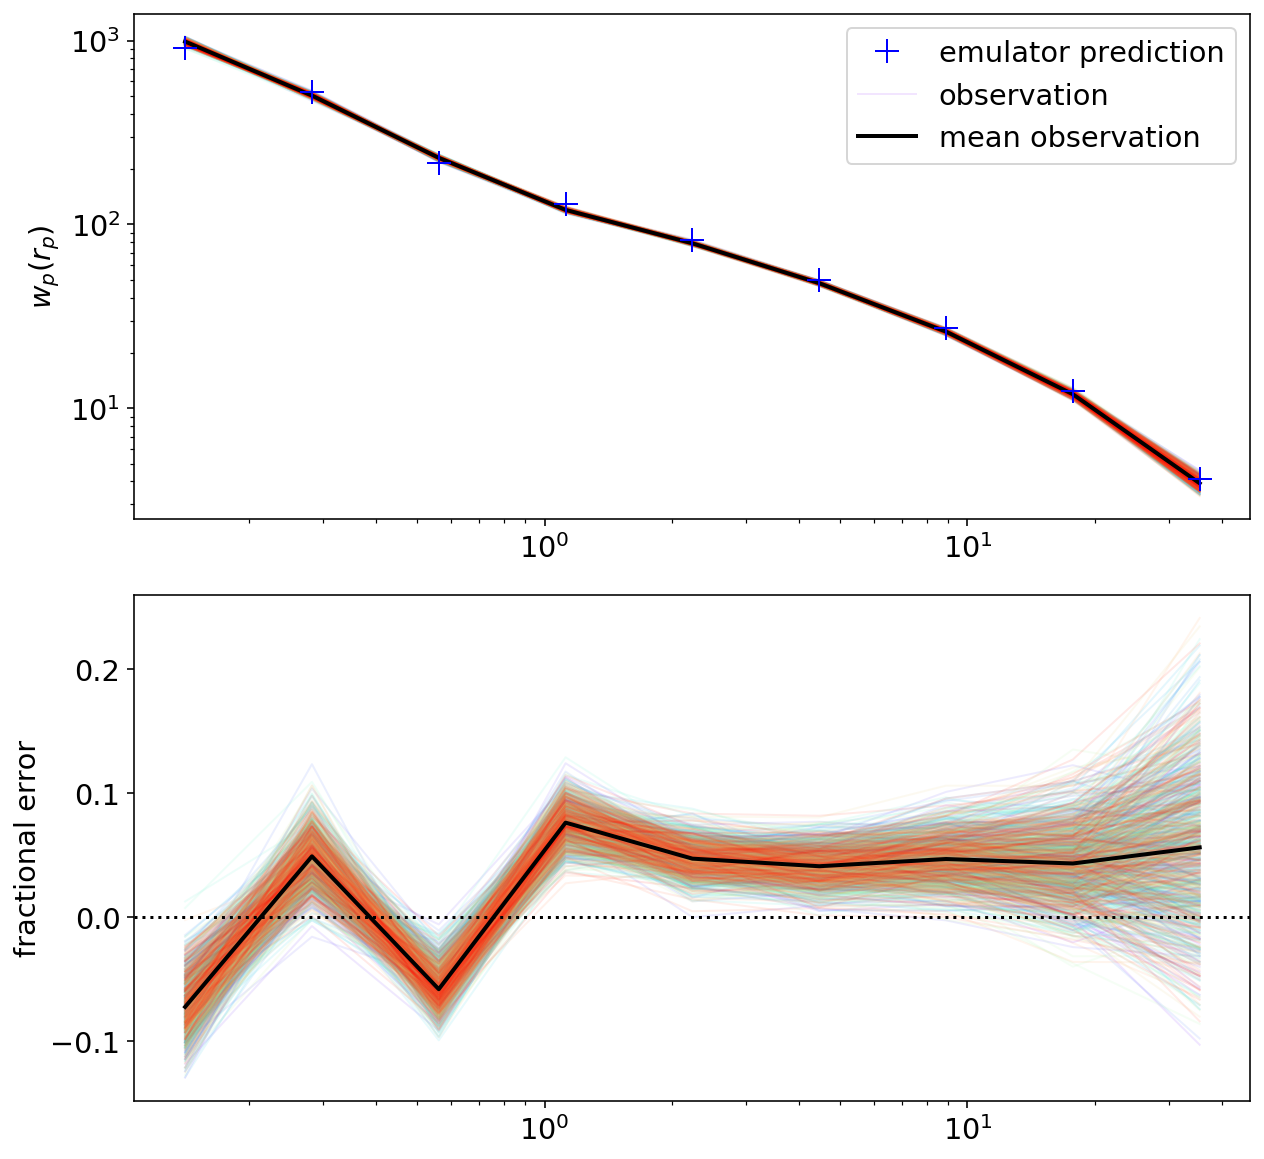

In [5]:
statistic = 'wp'
traintag = '_nonolap'
testtag = '_glam'
errtag = '_hod3_test0'
nhod = 100
kernel_name = 'M32ExpConst2'
savetag = ''

tag = '_log_k{}_{}hod'.format(kernel_name, nhod)
gptag = traintag + errtag + tag
acctag = gptag + testtag + savetag
fracerrs = plot_accuracy_glam(statistic, testtag, acctag, errtag)

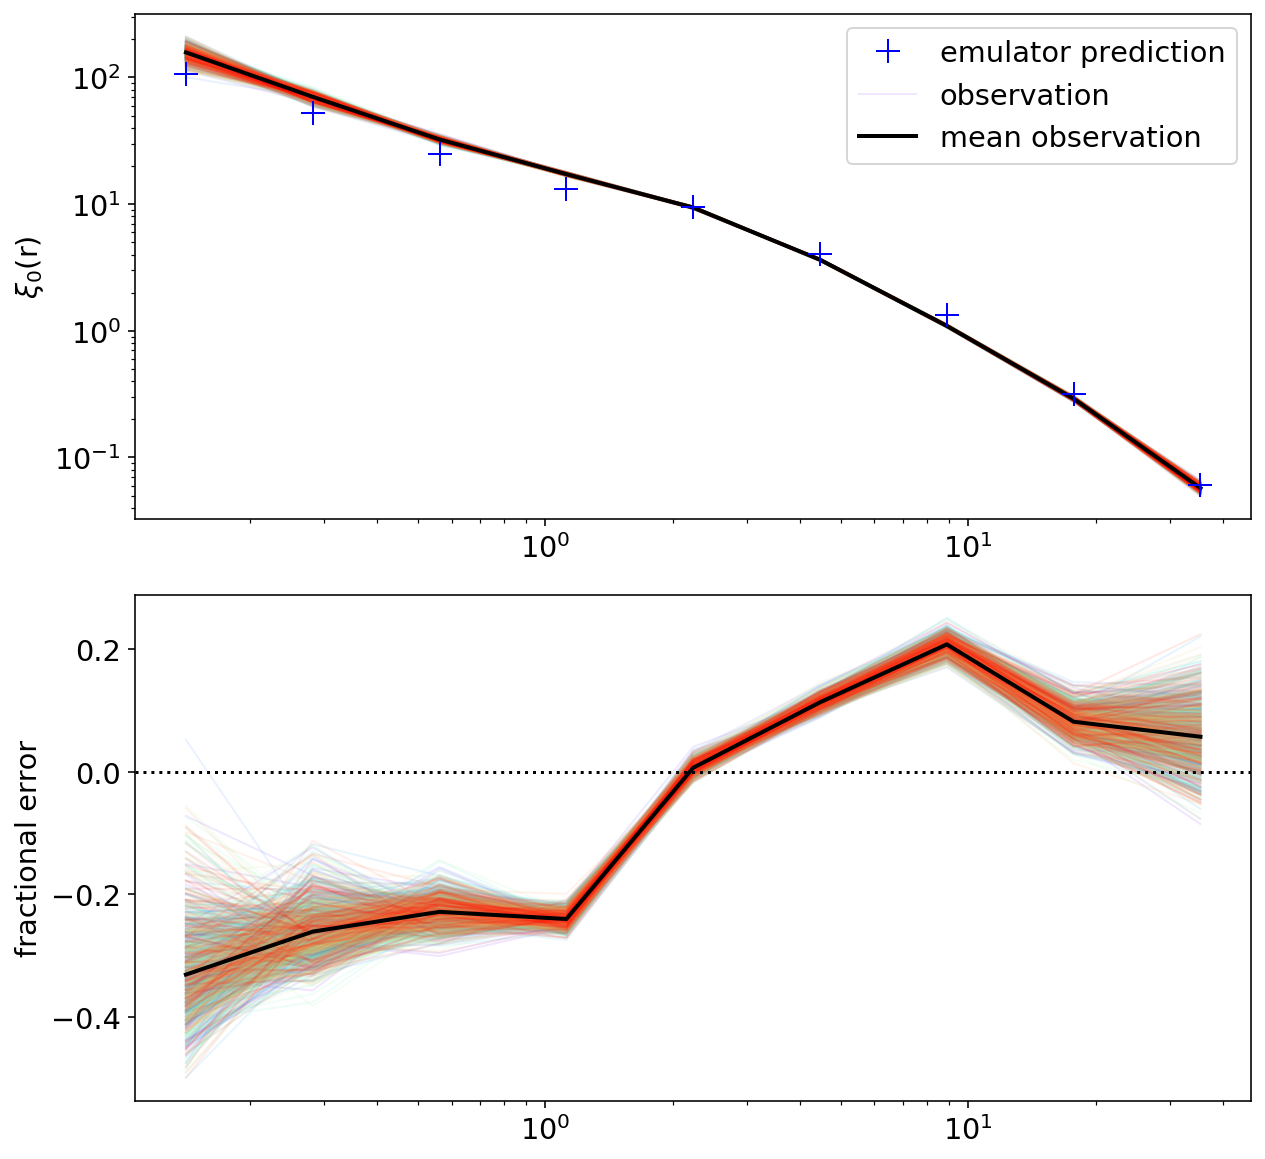

In [6]:
statistic = 'xi'
traintag = '_nonolap'
testtag = '_glam'
errtag = '_hod3_test0'
nhod = 100
kernel_name = 'M32ExpConst'
savetag = ''

tag = '_log_k{}_{}hod'.format(kernel_name, nhod)
gptag = traintag + errtag + tag
acctag = gptag + testtag + savetag
fracerrs = plot_accuracy_glam(statistic, testtag, acctag, errtag)

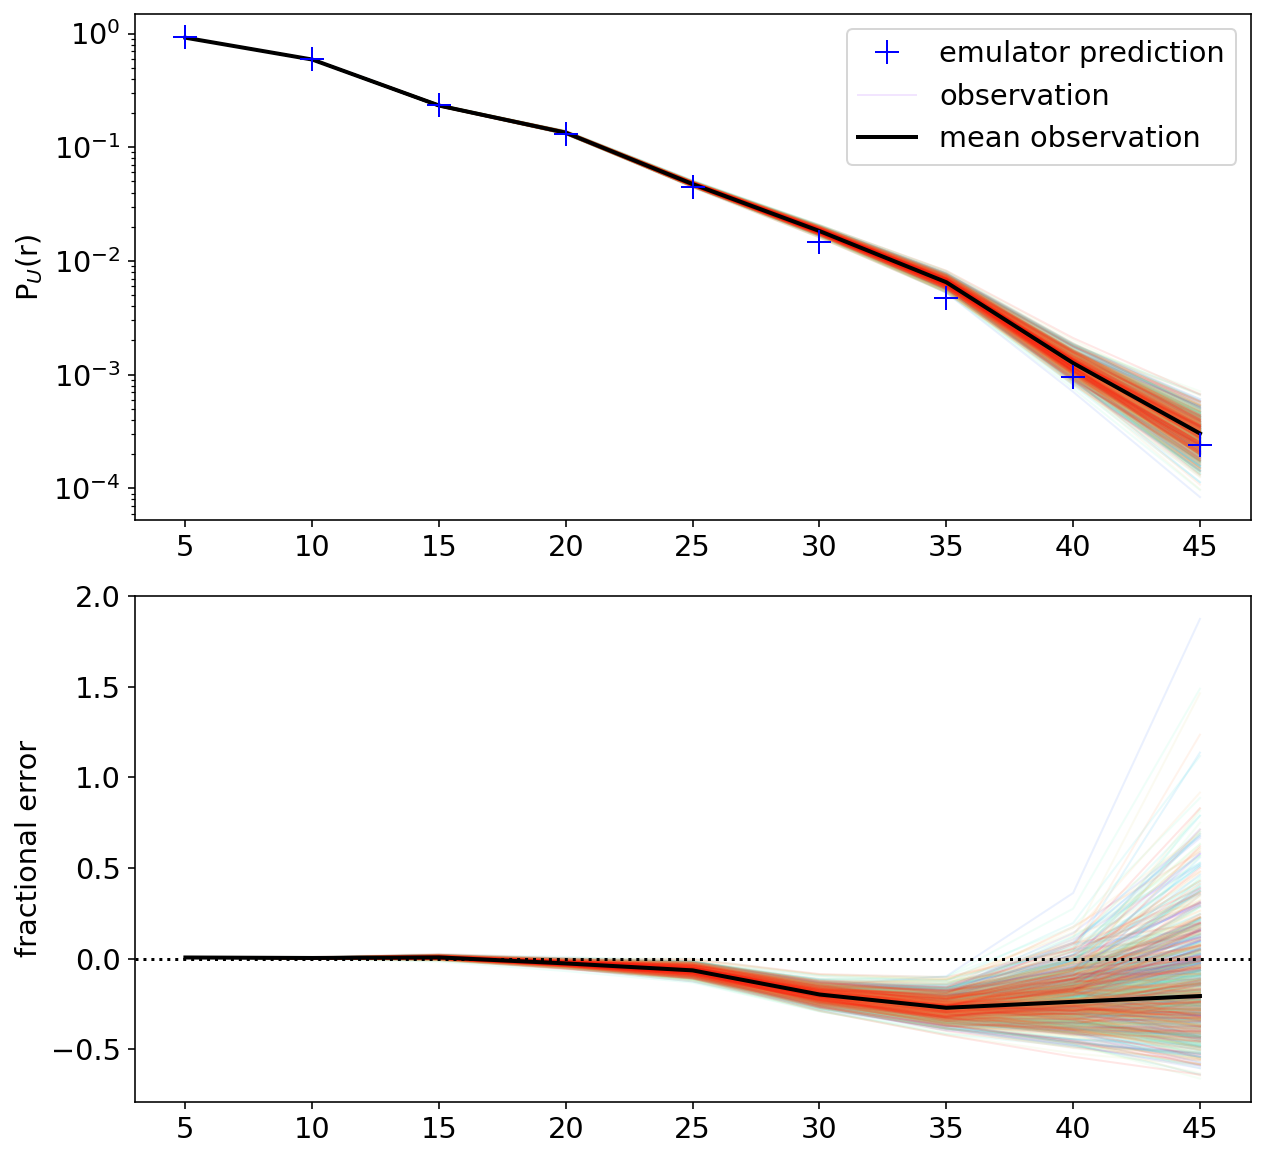

In [7]:
statistic = 'upf'
traintag = '_nonolap'
testtag = '_glam'
errtag = '_hod3_test0'
nhod = 100
kernel_name = 'M32ExpConst'
savetag = ''

tag = '_log_k{}_{}hod'.format(kernel_name, nhod)
gptag = traintag + errtag + tag
acctag = gptag + testtag + savetag
fracerrs = plot_accuracy_glam(statistic, testtag, acctag, errtag)

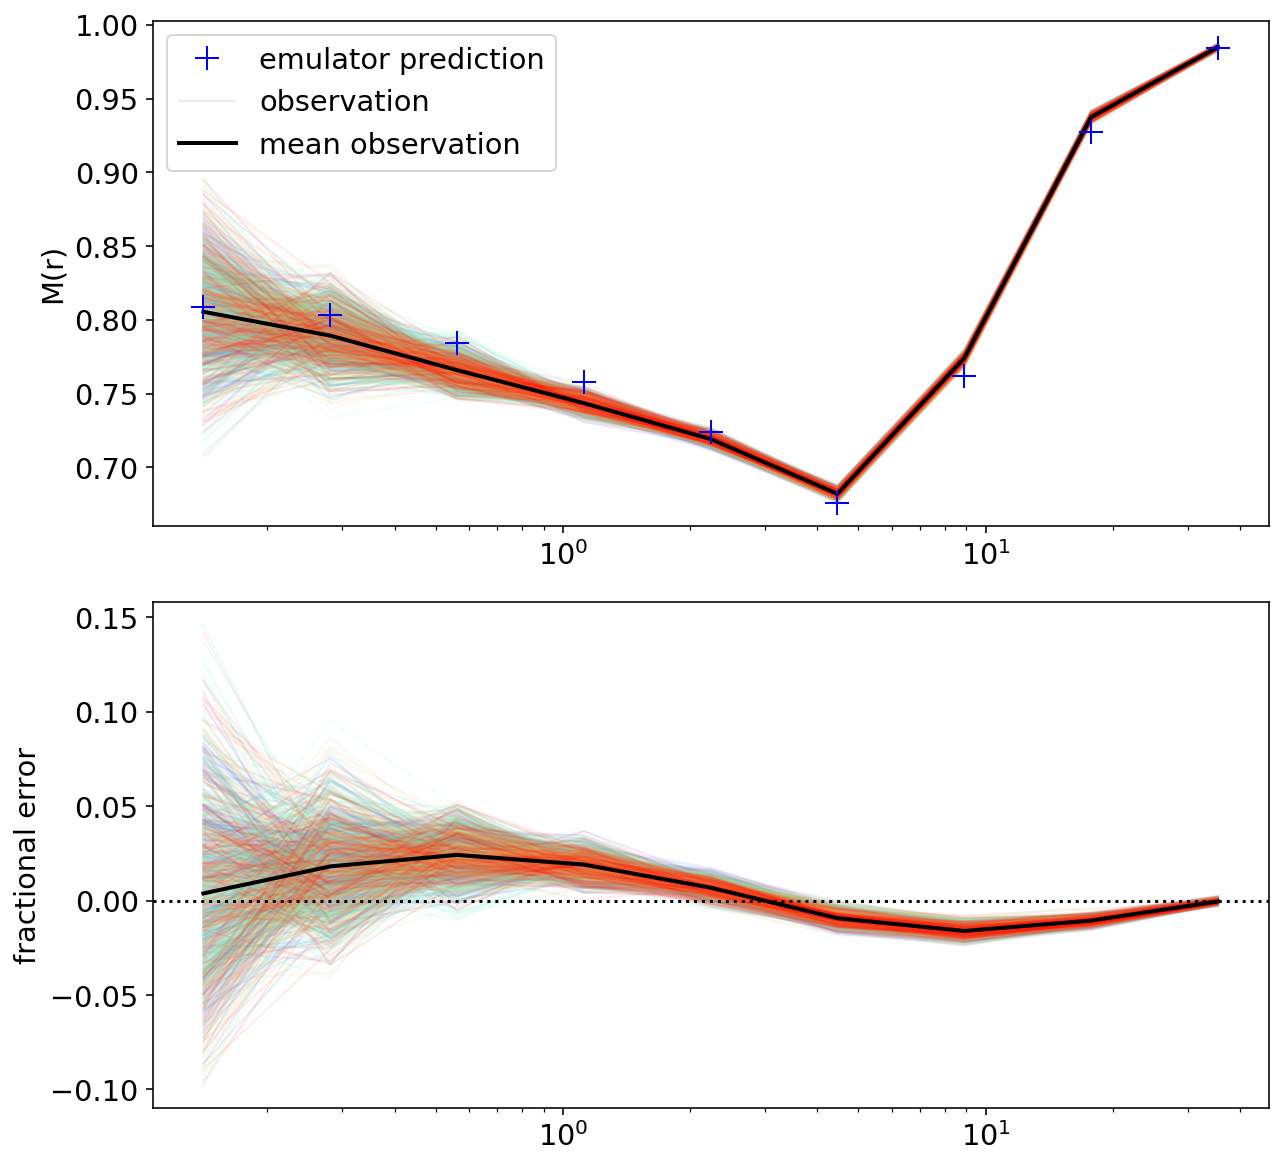

In [8]:
statistic = 'mcf'
traintag = '_nonolap'
testtag = '_glam'
errtag = '_hod3_test0'
nhod = 100
kernel_name = 'M32ExpConst'
savetag = ''

tag = '_log_k{}_{}hod'.format(kernel_name, nhod)
gptag = traintag + errtag + tag
acctag = gptag + testtag + savetag
fracerrs = plot_accuracy_glam(statistic, testtag, acctag, errtag)

# Covariance

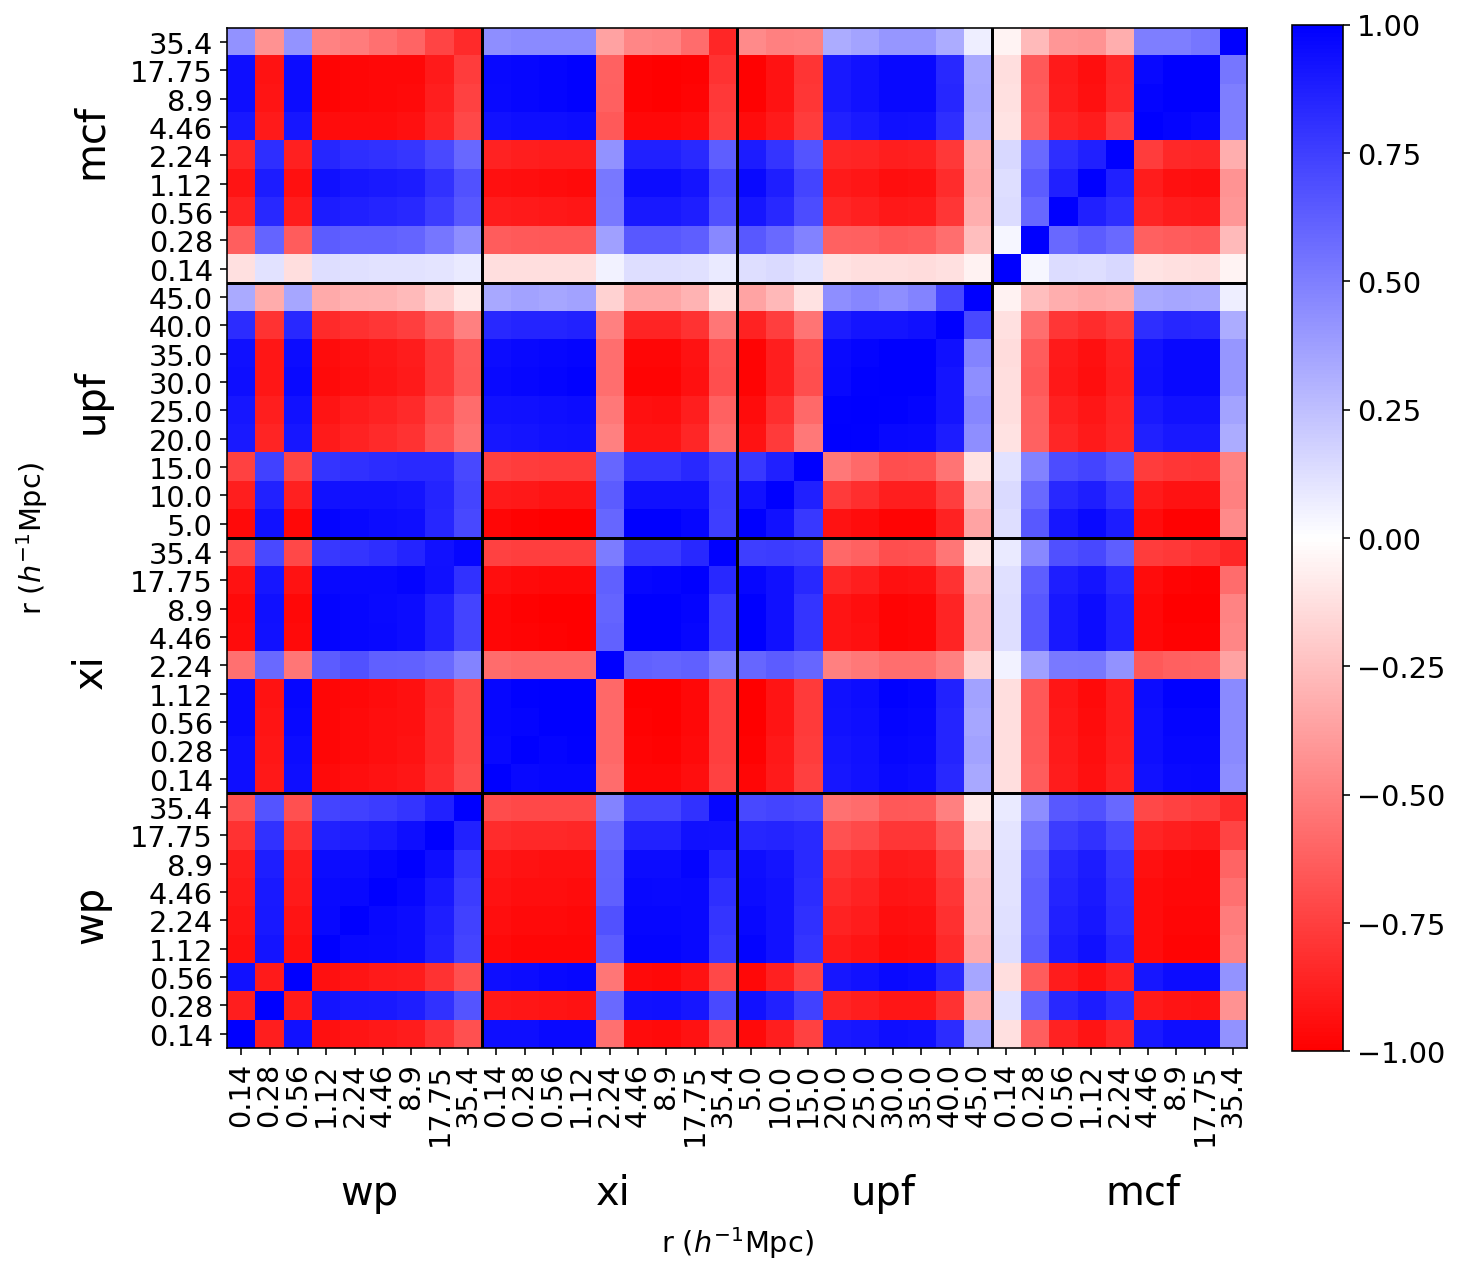

In [8]:
cov_emuperf_glam = utils.get_cov(statistics_all, 'emuperf', tag_str='_nonolap_hod3_test0_glam')
corr_emuperf_glam = utils.reduced_covariance(cov_emuperf_glam)
plotter.plot_correlation_matrix(corr_emuperf_glam, statistics_all)

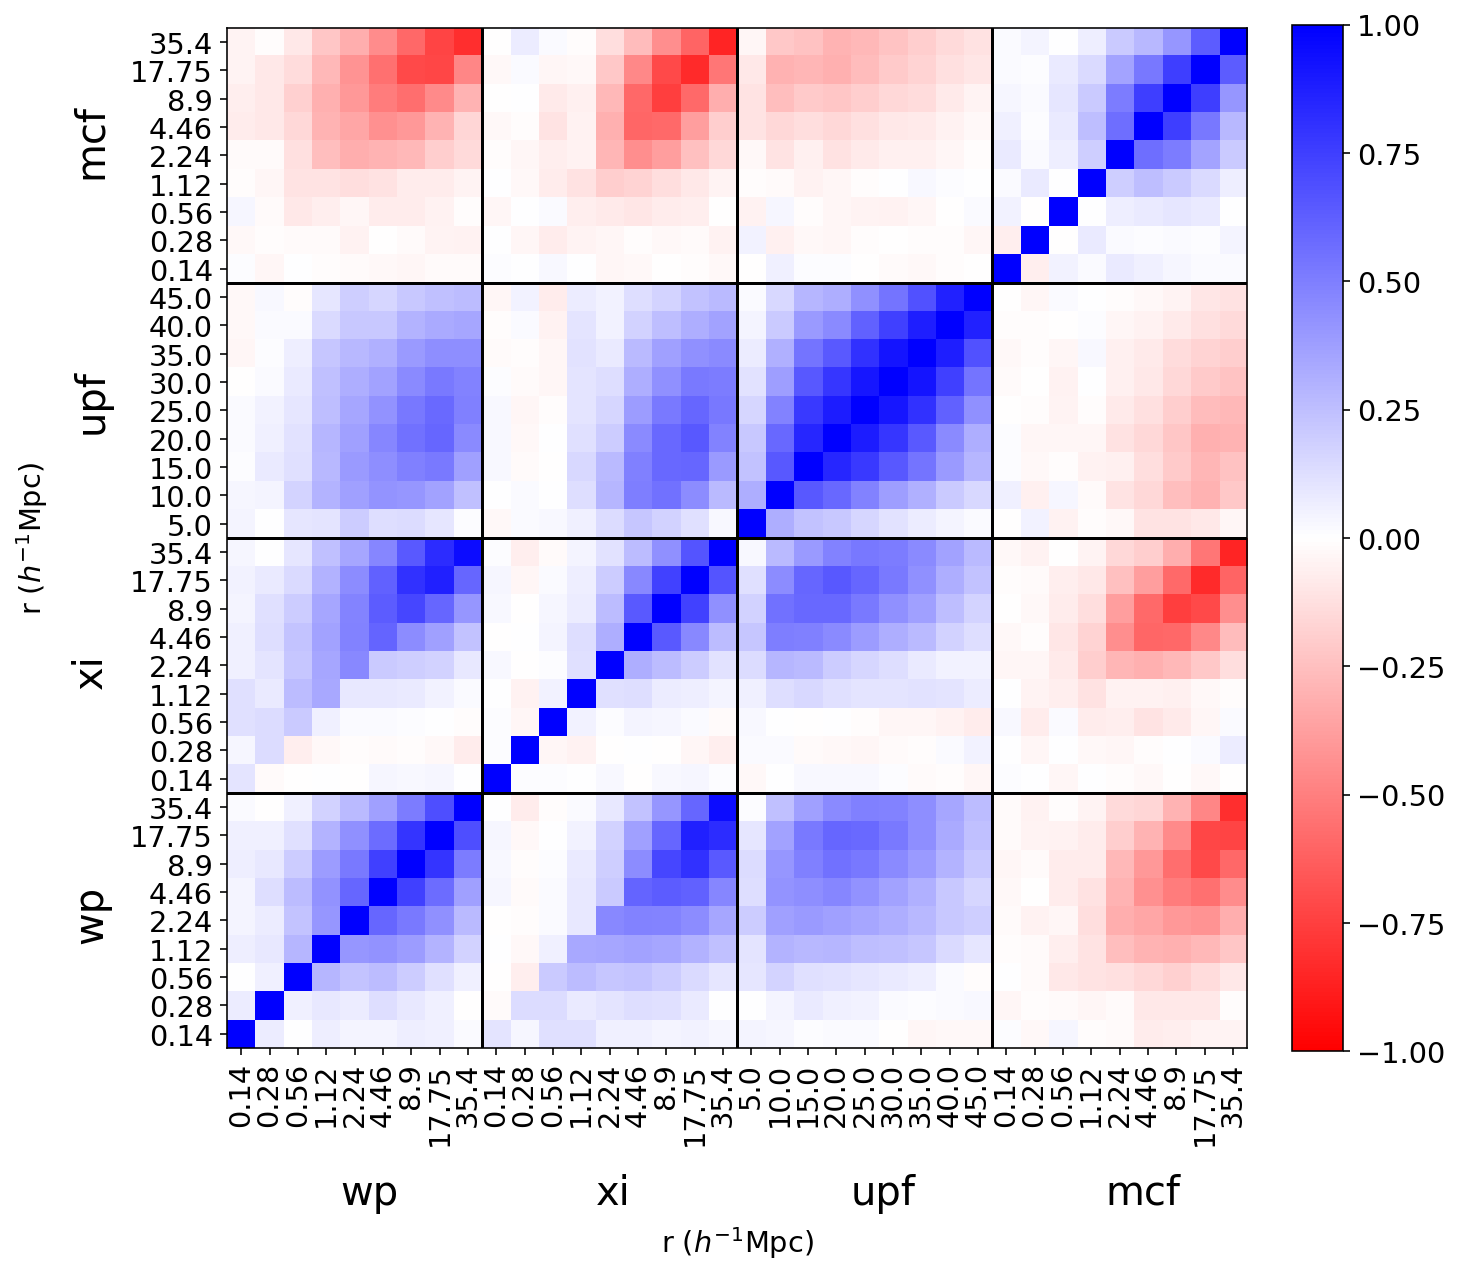

In [9]:
cov_emuperf_glam = utils.get_cov(statistics_all, 'emuperf', tag_str='_nonolap_hod3_test0_glam_residuals')
corr_emuperf_glam = utils.reduced_covariance(cov_emuperf_glam)
plotter.plot_correlation_matrix(corr_emuperf_glam, statistics_all)

In [11]:
L_glam = 1000.
L_aemulus = 1050.

In [14]:
cov_emuperf_aemulus = utils.get_cov(statistics_all, 'emuperf', tag_str='_nonolap_hod3_test0_mean_test0')
cov_emuperf_glam = utils.get_cov(statistics_all, 'emuperf', tag_str='_nonolap_hod3_test0_glam_residuals')

cov_test_glam = utils.get_cov(statistics_all, 'glam')
cov_test_aemulus_1box = utils.get_cov(statistics_all, 'aemulus', tag_str='_hod3_test0')

cov_test_glam_scaled = cov_test_glam*(1/5)*(L_glam/L_aemulus)**3
cov_test_aemulus_5box = cov_test_aemulus_1box*(1/5)

cov_emu_aemglam = cov_emuperf_aemulus - cov_test_glam_scaled
cov_emu_glam = cov_emuperf_glam - cov_test_glam_scaled

In [15]:
color_glam = 'magenta'
color_aemulus = 'blue'
color_emuperf = 'green'

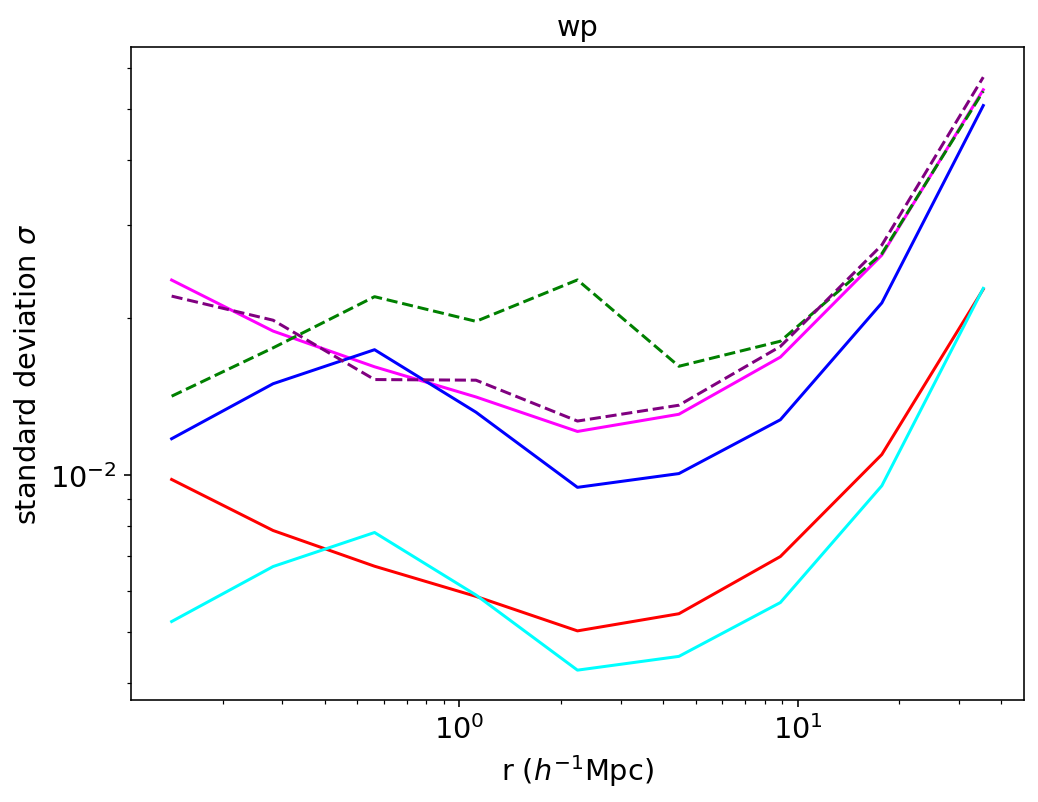

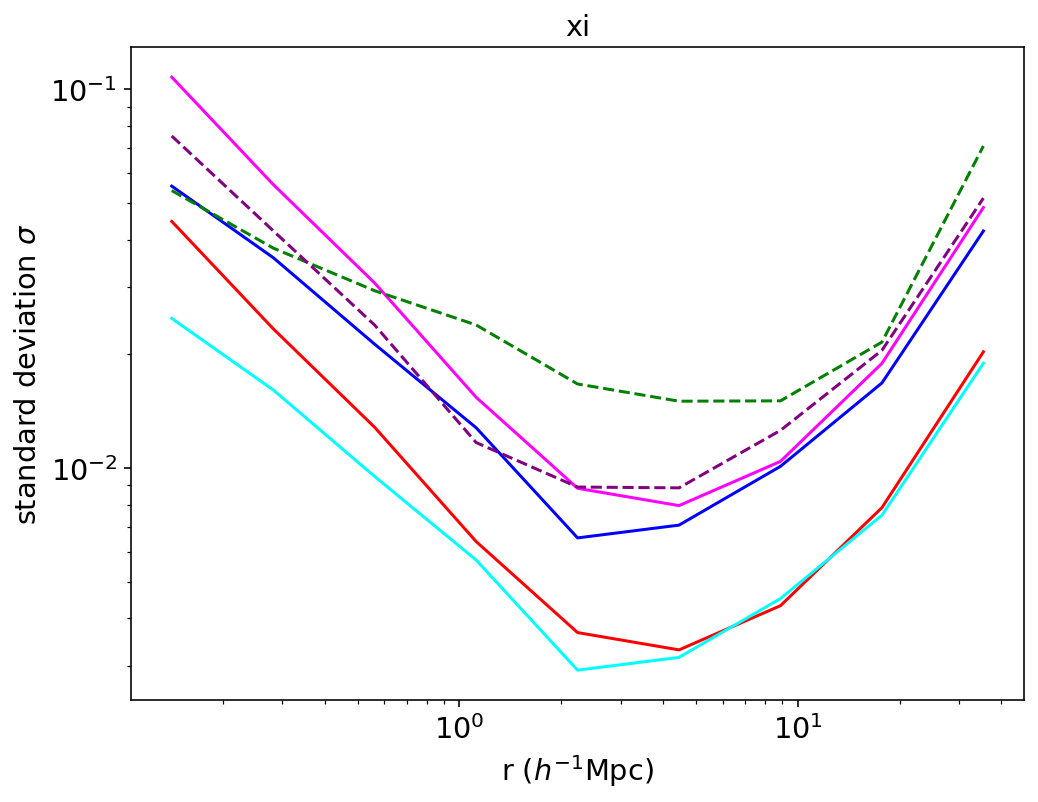

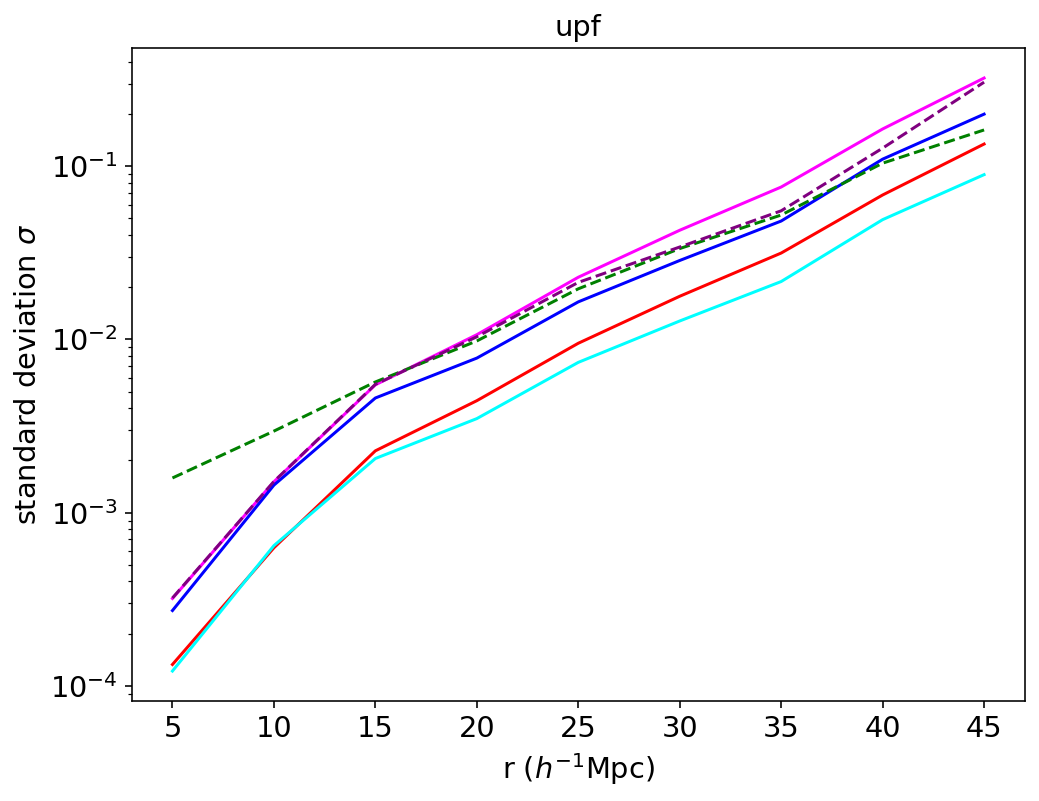

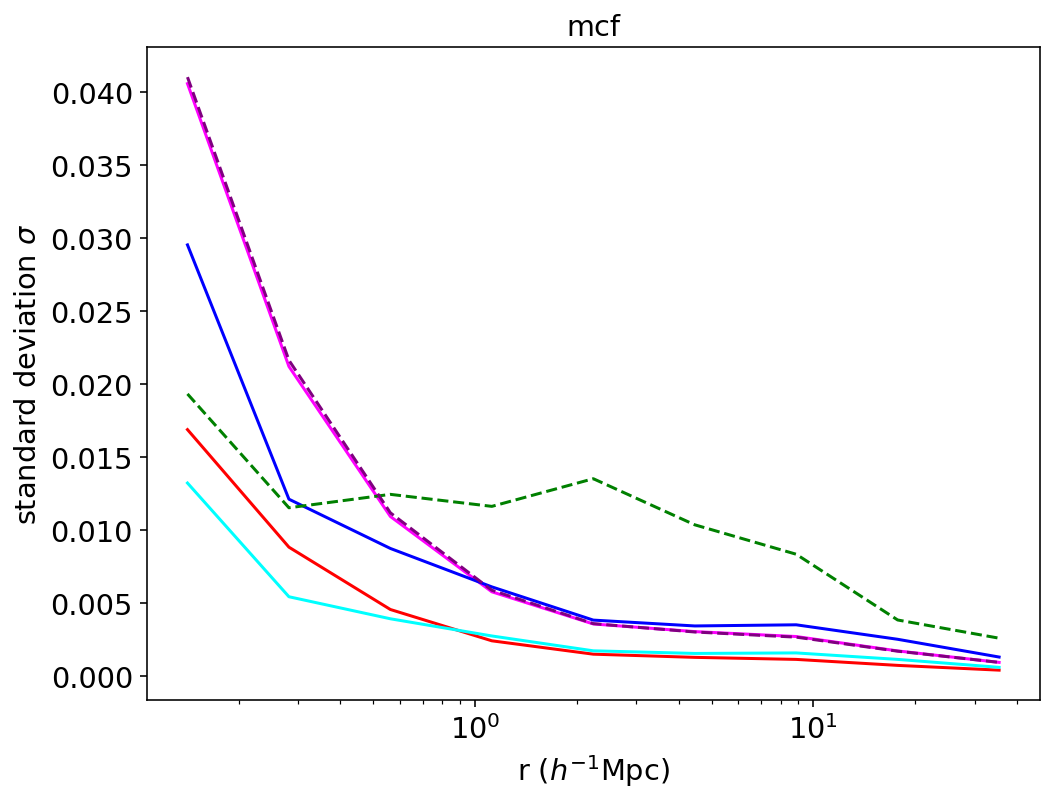

In [30]:
covs = [cov_test_glam, cov_test_glam_scaled, cov_test_aemulus_1box, cov_test_aemulus_5box, 
        cov_emuperf_aemulus, cov_emuperf_glam,
        #cov_emu_aemglam, cov_emu_glam
       ]
colors = [color_glam, 'red', color_aemulus, 'cyan',
          color_emuperf, 'purple', 
         # 'orange', 'grey'
         ]
labels = [r'$C_\mathrm{test,GLAM}$', 
          r'$C_\mathrm{test,GLAMscaled}$', 
          r'$C_\mathrm{test,Aemulus1Box}$', 
          r'$C_\mathrm{test,Aemulus5Box}$',
          r'$C_\mathrm{perf,Aemulus5Box}$',
          #r'$C_\mathrm{perf,GLAMwithaemulus} = C_\mathrm{emu} + C_\mathrm{test,Aemulus5Box}$',
          r'$C_\mathrm{perf,GLAMresiduals}$',
          #r'$C_\mathrm{emu} = C_\mathrm{perf,Aemulus5Box} - C_\mathrm{test,GLAMscaled}$',
          #r'$C_\mathrm{emu} = C_\mathrm{perf,GLAMdirect} - C_\mathrm{test,GLAMscaled}$',
         ]
plot_diagonal_covariance(statistics_all,
                         covs, 
                         colors,
                         labels,
                         plot_stdev=True,
                         show_legend=False)

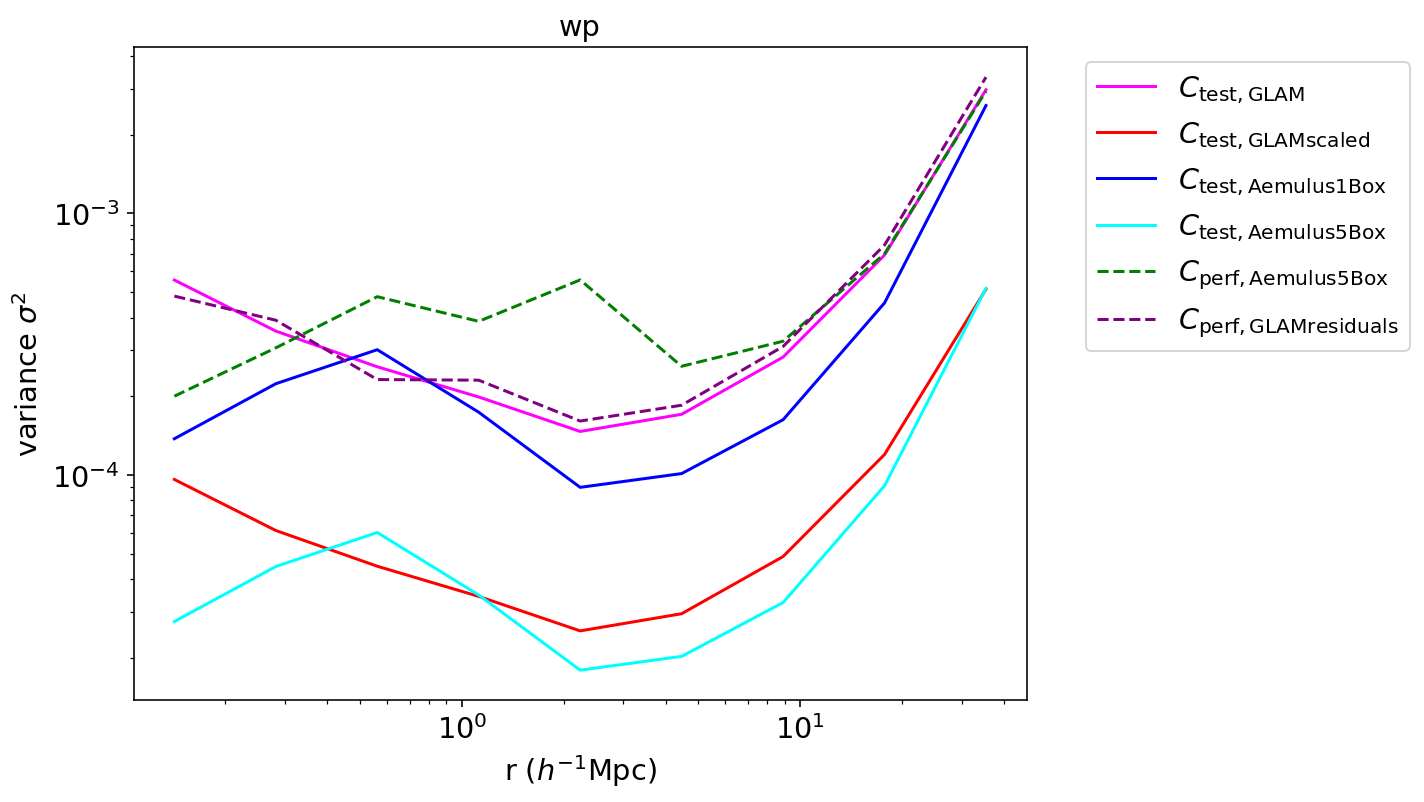

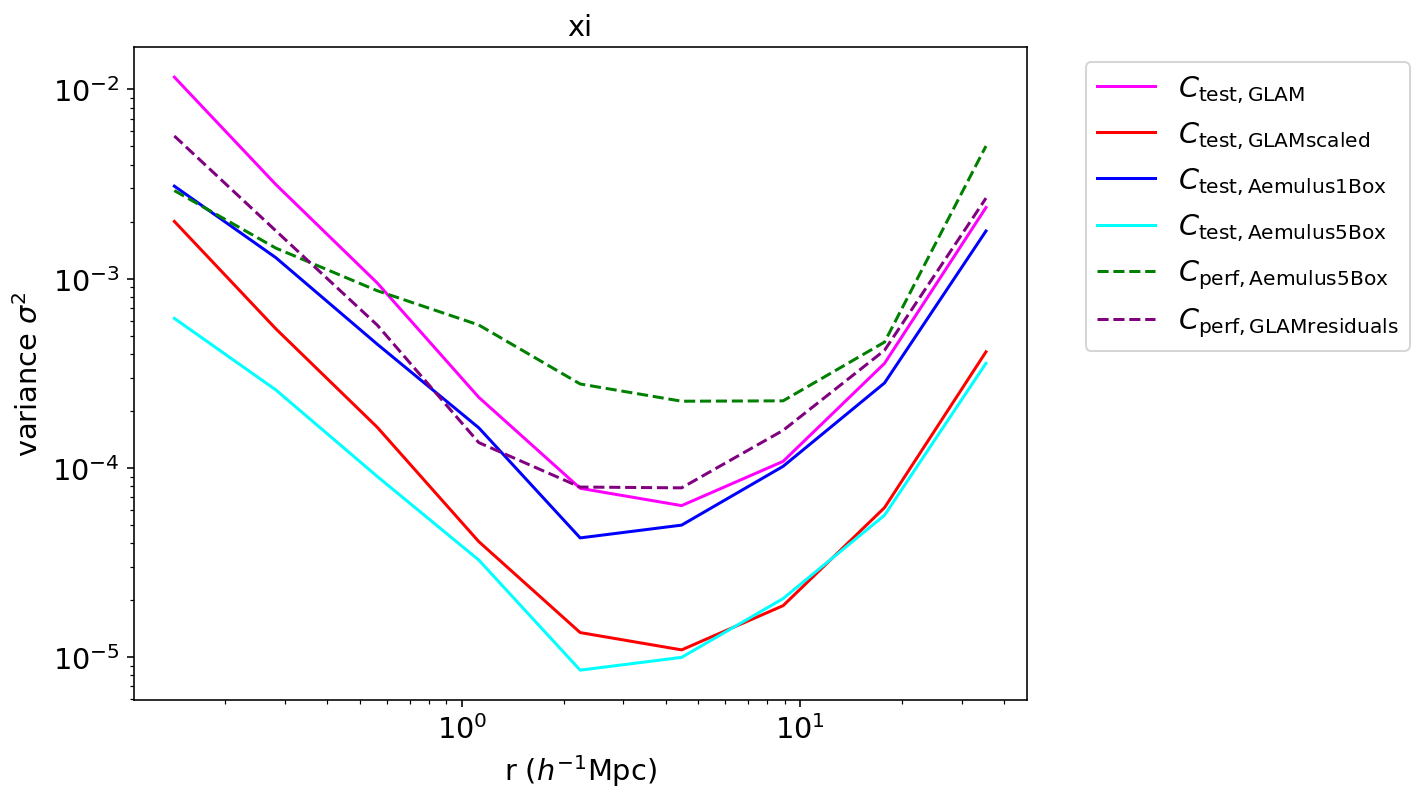

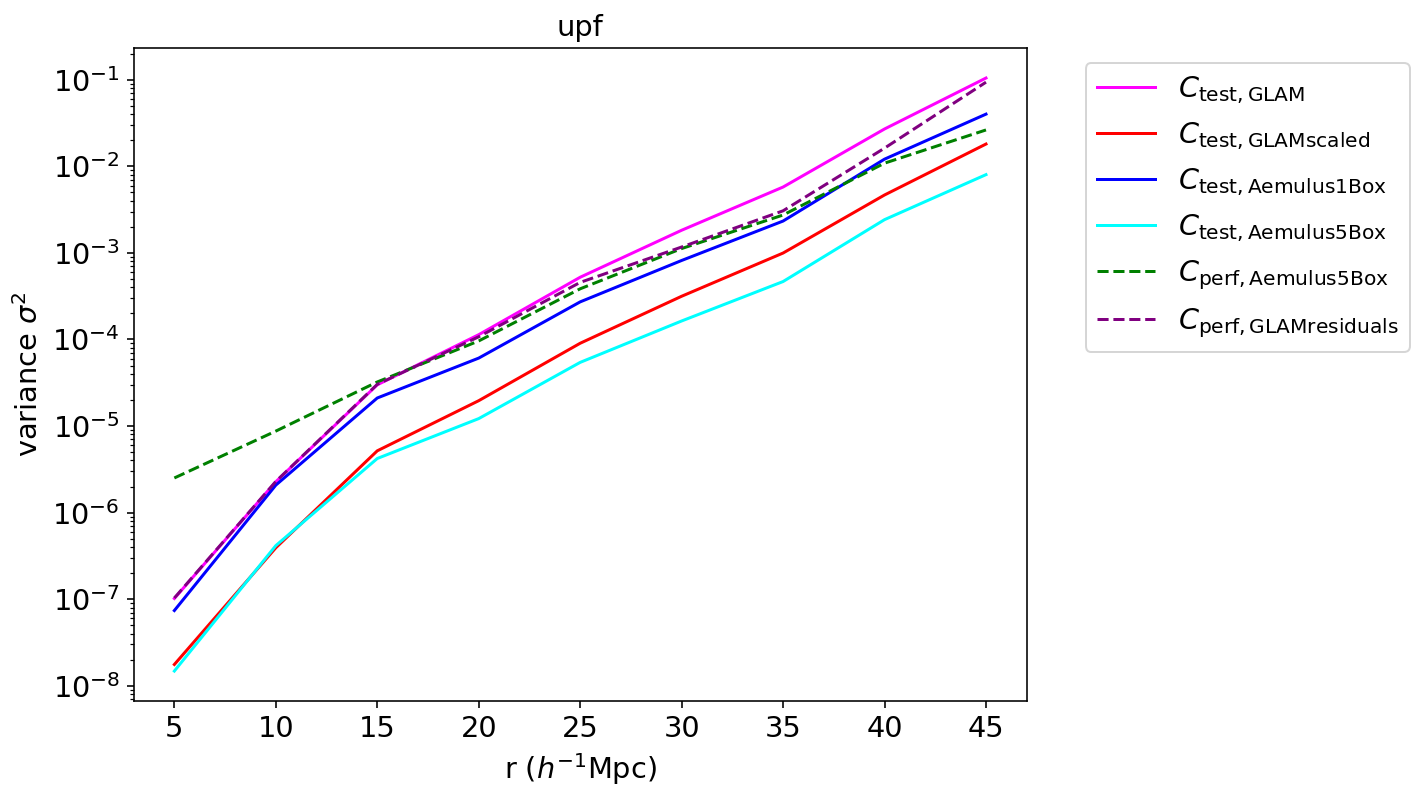

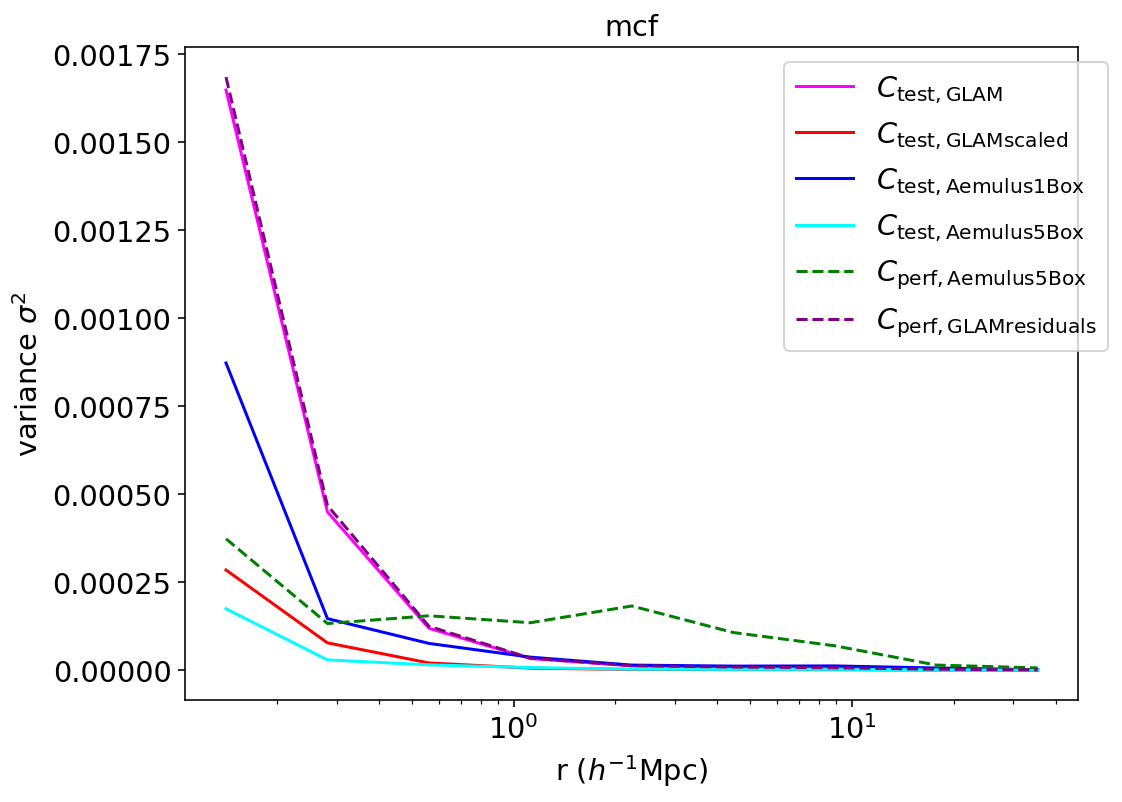

In [29]:
plot_diagonal_covariance(statistics_all,
                         covs, 
                         colors,
                         labels,
                         plot_stdev=False,
                         show_legend=True)